<a href="https://colab.research.google.com/github/LLT9798/Twitter_User_Gender_Age_Prediction/blob/master/Model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
%matplotlib notebook
from sklearn.utils import shuffle

!pip install nltk;
!pip install emojis;
nltk.download('wordnet')
#pre-processing
import re
import nltk
from nltk.stem import WordNetLemmatizer 
import emojis
import regex

# pytorch transformers
!pip install pytorch_pretrained_bert;
!pip install transformers;
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
import transformers as ppb 

#modeling
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

#CV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from numpy import array
from sklearn.model_selection import KFold

# Authenticate and create the PyDrive client.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [17]:
link = 'https://drive.google.com/open?id=1x__GAttdEtRo8NjhItfaqATBlqxrcV7w'

fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('label_cleaned.csv')
df = pd.read_csv('label_cleaned.csv')
df.shape

(2667, 15)

In [18]:
df = df[['text', 'description', 'profile_sidebar_fill_color', 'gender']]
df.rename(columns={'profile_sidebar_fill_color':'sidebar_color'}, inplace=True)
#the model's main purpose is detecting gender, so we didn't pick 'location' feature
df.dropna(inplace = True)
df.drop(df[(df['gender'] == 'n') | 
           (df['gender'] == 'b')].index, inplace = True)

In [19]:
emoji_count1 = df['text'].apply(lambda x : emojis.count(str(x)))
emoji_count2 = df['description'].apply(lambda x : emojis.count(str(x)))
df['emoji']= emoji_count1 + emoji_count2

pd.options.display.max_colwidth = 9999
df.head(5)

,text,description,sidebar_color,gender,emoji
0,every action movie: \n“how many minutes do you need?” \n“this many minutes” \n“YOU HAVE A SOMEWHAT SMALLER NUMBER OF MINUTES”,25 • they/she • MFA playwright • published model • co-writer @ThankYou5Show • @blackouttheatre • put the ho in stay the fuck home,DDEEF6,0,0
1,@myotical sad girl cries from my barren American Netflix :'(,"23, she/her, artist & animal crossing lover - currently living it up on the isle of misthaven✌️💕 catch me elsewhere: https://linktr.ee/allmadihere ✨",DDEEF6,0,3
2,"It’s not the rapist, it’s the child who’s the villain!",99% sarcasm & righteous indignation. She/her. @mythsbaby is my podcast. I'm pretty honest about how shitty men were. Listen: http://apple.co/2uIOHS0,C9C1C9,0,0
3,@xXAutumnIvyXx This Cosplay is incredible and after seeing it I wouldn't mind a female Crow movie! Thank you for sh… https://t.co/koJeSO7icX,"24|he/him|Straight|.Weeb.Loyal Friend. Team Rep for the Corgi Corps. #PawsUp🐾🐾Outlaws, Fusion and Reign are my teams baby! NSFW Post! #UpTheAnte #LetItReign",000000,1,2
4,"@JUSOPP are you saying that it's not worth it? I can watch those super secret youtubes now that ARE premium-only, a… https://t.co/TKoFLvRwNx","33 year old female. OLDER BABIES! \o/→#personalaccount o3o♥ Lil dose of sunsh- mostly rants, really. Need For Speed, Battlefield 3, art, traces, redraws, OCs.",DDEEF6,0,0


In [20]:
def doc_features(doc):
    #HTML & @ 
    pattern = r'(http\S+)|(@\S+)|(#\S+)'
    documents = re.sub(pattern, ' ', doc)

    #To lower case & breakdown words
    words = documents.lower().split()

    #Stemmer & Return
    features = []
    stemmer = WordNetLemmatizer()
    for word in words:
        word = re.sub('[^a-zA-Z]', ' ',word)
        features.append(stemmer.lemmatize(word))
        
    #remove blank    
    while("" in features) : 
        features.remove("") 
        
    return(features)
    
def text_cleaner(text):
    clean_text = []
    for i in text:
        clean_text.append(' '.join(doc_features(i)))
    
    return clean_text


df['text'] = text_cleaner(df['text']);
df['description'] = text_cleaner(df['description']);

#shuffle again
df = shuffle(df, random_state= 100)
df.reset_index(drop=True, inplace= True)
m2_df_level0 = df[['text', 'description', 'emoji', 'gender']]

#set 75% train & 25% hideout

trainindex = int(len(m2_df_level0)*0.8)-1
hideoutindex = trainindex + 1

print(trainindex, hideoutindex)

m2_df_level0_train = m2_df_level0[['text','description', 'emoji', 'gender']].loc[:trainindex]
m2_df_level0_hideout = m2_df_level0[['text','description', 'emoji', 'gender']].loc[hideoutindex:]

print (m2_df_level0_train.shape, m2_df_level0_hideout.shape)

1622 1623
(1623, 4) (406, 4)


In [ ]:
m2_df_level0_train.head(5)

,text,description,emoji,gender
0,but me putting on acrylic nail dressed normally a me or doing fantasy cosplays regular tv show cosplays etc a,jeremy he they your trans disabled cat dad who never ha enough coffee writer knitter cat foster wiccan an angry little sager,5,1
1,he so pretty in it it s about the thick old hollywood style makeup,him creative writer the world is good and we belong here evil twink arm candy check my carrd for fandoms pfp,3,1
2,you and it s not my favorite movie ever but def one of our mutual favorite lines which,dog lover hater beach native attorney i also draw things,9,0
3,check out my broadcast from my playstation live at,year old psn llpilsify sf pf for,0,1
4,all of the above he s also an obvious drug user when you watch him on tv why ca,american immigrant but always a scot army wife mother dog lover go joe biden jaime harrison joe cunningham,0,0


In [22]:
#BERT
def text_vec_convert2(X_train, X_test):
    model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 
                                                    'distilbert-base-uncased')
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)
    
    tokenized_train = X_train.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    tokenized_test = X_test.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

    padded_train = go_padded(tokenized_train)
    padded_test = go_padded(tokenized_test)
    
    features_train = transform(padded_train, model)
    features_test = transform(padded_test, model)
   
    return(features_train, features_test)
    
def go_padded(token):
    max_len = 0
    
    for i in token.values:
        if len(i) > max_len:
            max_len = len(i)
    
    padded = np.array([i + [0]*(max_len-len(i)) for i in token.values])
    return padded

def transform(padded, model):
    input_ids = torch.tensor(np.array(padded))
    with torch.no_grad():
        last_hidden_states = model(input_ids)  
    
    attention_mask = np.where(padded != 0, 1, 0)
    attention_mask.shape    
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)
    
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)    
    features = last_hidden_states[0][:,0,:].numpy()    
    
    return features
#BERT_______END

def m2_lv0_modeling(X_train, y_train, X_column):
    
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_train, y_train,
                                                                        test_size=0.50, random_state=100)
    estimators=[
        ('logistic',LogisticRegression(solver='liblinear',penalty='l2')),
        ('lasso',LogisticRegression(solver='liblinear',penalty='l1')),
        ('elasticnet',SGDClassifier(loss='log', penalty='elasticnet')),
        ('random_forest',RandomForestClassifier()),
        ('adaBoost', AdaBoostClassifier()),
        ('Grbf', GaussianProcessClassifier(1.0 * RBF(1.0))),
        ('deep_nn',MLPClassifier(solver= 'lbfgs', max_iter= 400)),
        ('GNB', GaussianNB())
        ]
    
    pipes=[]
    model_name = []
    pred_sub_df = pd.DataFrame({'clf_name':[], 'prob_male':[]})
    for model in estimators:
        pipe=Pipeline(steps=[(model)])
        pipe.fit(X_sub_train,y_sub_train)
        
        print(model[0], 'accuracy:', pipe.score(X_sub_test, y_sub_test))
        pred_sub = pipe.predict_proba(X_sub_test)
        pred_sub_df_temp = pd.DataFrame({'clf_name': X_column + '_' + model[0], 
                                         'prob_male':pred_sub[m, 1]} for m in range(len(pred_sub)))
        pred_sub_df = pred_sub_df.append(pred_sub_df_temp, sort= False)
        
        pipes.append(pipe)
        model_name.append(model[0])
     
    #return trained classfiers
    return pipes, model_name, pred_sub_df, y_sub_test


def m2_lv0_wrap(X_train, X_test, y_train):
    
    #take column name
    X_column = X_train.name
    
    #text vectorize
    X_train, X_test = text_vec_convert2(X_train, X_test)
    
    #modeling & get clf
    clfs, clf_names, pred_sub_df, y_sub_test = m2_lv0_modeling(X_train, y_train, X_column)
    
    #apply X_test to clf for prediction
    prediction_df = pd.DataFrame({'clf_name':[], 'prob_male':[]})
    for i , j in zip(clfs, clf_names):
        pred = i.predict_proba(X_test)
        prediction_df_temp = pd.DataFrame({'clf_name': X_column + '_' + j,
                                           'prob_male':pred[m, 1] } for m in range(len(pred)))
        prediction_df = prediction_df.append(prediction_df_temp, sort= False)
    #pivot prediction output
    prediction_df = prediction_df.pivot(index= None, columns= 'clf_name', values= 'prob_male')
    
    
    return prediction_df, pred_sub_df, y_sub_test

In [23]:
# y_test remains secret to clfs
m2_prediction_text, m2_subpred_text, y_sub_test = m2_lv0_wrap(m2_df_level0_train['text'], 
                                                                     m2_df_level0_hideout['text'],
                                                                     m2_df_level0_train['gender'])

m2_prediction_desc, m2_subpred_desc, y_sub_test = m2_lv0_wrap(m2_df_level0_train['description'], 
                                                                     m2_df_level0_hideout['description'],
                                                                     m2_df_level0_train['gender'])


logistic accuracy: 0.5344827586206896
lasso accuracy: 0.5652709359605911
elasticnet accuracy: 0.5135467980295566
random_forest accuracy: 0.5899014778325123
adaBoost accuracy: 0.5714285714285714
Grbf accuracy: 0.5307881773399015
deep_nn accuracy: 0.520935960591133
GNB accuracy: 0.6083743842364532
logistic accuracy: 0.8596059113300493
lasso accuracy: 0.8435960591133005
elasticnet accuracy: 0.6810344827586207
random_forest accuracy: 0.7869458128078818
adaBoost accuracy: 0.7733990147783252
Grbf accuracy: 0.4938423645320197
deep_nn accuracy: 0.8177339901477833
GNB accuracy: 0.6761083743842364


In [ ]:
# Gathering Train set from inner loop

m2_subpred_text = m2_subpred_text.pivot(index= None, columns= 'clf_name', values= 'prob_male')
m2_subpred_desc = m2_subpred_desc.pivot(index= None, columns= 'clf_name', values= 'prob_male')

y_sub_test.reset_index(drop= True, inplace= True)
m2_df_level1_train = pd.concat([m2_subpred_text, m2_subpred_desc, y_sub_test], axis= 1)
pd.set_option('display.max_colwidth', -1)
m2_df_level1_train.shape

# Gathering Valdate set from Hideout

m2_df_level0_hideout['gender'].reset_index(drop= True, inplace= True)
m2_df_level1_val = pd.concat([m2_prediction_text, m2_prediction_desc, m2_df_level0_hideout['gender']], axis= 1)
pd.set_option('display.max_colwidth', -1)
m2_df_level1_val.shape

In [25]:
m2_X_train = m2_df_level1_train.loc[:, m2_df_level1_val.columns != 'gender']
m2_y_train = m2_df_level1_train['gender']

m2_X_val = m2_df_level1_val.loc[:, m2_df_level1_val.columns != 'gender'] 
m2_y_val = m2_df_level1_val['gender']

print(m2_X_train.shape)

(812, 16)


In [26]:
def m2_simple_lv1(X_train, X_test, y_train, y_test):

    estimators=[
        ('logistic',LogisticRegression(solver='liblinear',penalty='l2')),
        ('lasso',LogisticRegression(solver='liblinear',penalty='l1')),
        ('elasticnet',SGDClassifier(loss='log', penalty='elasticnet')),
        ('random_forest',RandomForestClassifier()),
        ( 'adaBoost', AdaBoostClassifier()),
        ('SVCrbf', SVC(kernel= 'rbf')),
        ('SVClinear',SVC(kernel="linear")),
        ('LSVC', LinearSVC()),
        ('Grbf', GaussianProcessClassifier(1.0 * RBF(1.0))),
        ('deep_nn',MLPClassifier()),
        ('knn',KNeighborsClassifier(n_neighbors=5,weights='distance',algorithm='auto')),
        ('GNB', GaussianNB())
        ]
    
    scores=[]
    for model in estimators:
        pipe=Pipeline(steps=[(model)])
        pipe.fit(X_train, y_train)
        score = pipe.score(X_test, y_test)
        scores.append([score, model])
        
        
    return (scores)

In [ ]:
m2_scores = m2_simple_lv1(m2_X_train, m2_X_val, m2_y_train, m2_y_val)
m2_scores

In [28]:
from sklearn.metrics import multilabel_confusion_matrix
import sklearn.metrics as skm

import seaborn as sn
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

def ROCChart(clf, y_true, y_proba):
  
  fpr, tpr, _ = roc_curve(y_true,  y_proba, pos_label= '1')
  auc = roc_auc_score(y_true, y_proba)
  result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
  result_table = result_table.append({'classifiers':clf.__class__.__name__ ,
                                      'fpr':fpr, 
                                      'tpr':tpr, 
                                      'auc':auc}, ignore_index=True)
  result_table.set_index('classifiers', inplace=True)
  
  fig = plt.figure(figsize=(8,6))
  
  for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
    plt.plot([0,1], [0,1], color='orange', linestyle='--')
    
    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("Flase Positive Rate", fontsize=15)
    
    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)
    
    plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
    plt.legend(prop={'size':13}, loc='lower right')
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [29]:
parameters = {'criterion': ['entropy', 'gini'], 'n_estimators': [100, 1000, 2000], 'oob_score': ['True', 'False']}
grid_search = GridSearchCV(RandomForestClassifier(random_state= 24), parameters, cv=5, return_train_score=True)
grid_search.fit(m2_X_train, m2_y_train)


print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

best parameters:  {'criterion': 'gini', 'n_estimators': 2000, 'oob_score': 'True'}
best scrores:  0.8595849428160266


              precision    recall  f1-score   support

           0       0.87      0.83      0.85       196
           1       0.85      0.89      0.87       210

    accuracy                           0.86       406
   macro avg       0.86      0.86      0.86       406
weighted avg       0.86      0.86      0.86       406



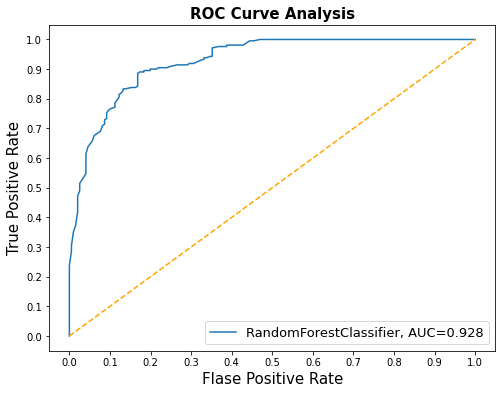

In [31]:
clfR = RandomForestClassifier(random_state= 100, criterion= 'entropy', n_estimators= 100, oob_score= True) 
clfR.fit(m2_X_train, m2_y_train)
clfR.score(m2_X_val, m2_y_val)

y_pred = clfR.predict(m2_X_val)
y_proba = clfR.predict_proba(m2_X_val)[::,1]
y_true = m2_y_val

print( skm.classification_report(y_true,y_pred))
ROCChart(clfR, y_true, y_proba)